In [2]:
import shutil
import os

if os.path.exists("logs"):
    shutil.rmtree("logs")
    print("Logs directory cleared")
else:
    print("No logs directory found")

Logs directory cleared


In [3]:
from utils import start_tensorboard

start_tensorboard()

⚠️  Warning: Logs directory not found at /Users/philippgeppner/LectureNotes/exercise_10/logs


# Convolutional Neural Networks: Image Classification with CNNs
Moving beyond fully connected networks, we explore Convolutional Neural Networks (CNNs) designed specifically for image data. CNNs preserve spatial structure through convolutional layers, pooling operations, and hierarchical feature learning.

In [4]:
# load data
import keras
import numpy as np


(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()


X_train_scaled = X_train.astype("float32") / 255.0
X_test_scaled = X_test.astype("float32") / 255.0


y_train = y_train.flatten()
y_test = y_test.flatten()

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"Classes: {np.unique(y_train)}")

X_train: (50000, 32, 32, 3), y_train: (50000,)
X_test: (10000, 32, 32, 3), y_test: (10000,)
Classes: [0 1 2 3 4 5 6 7 8 9]


## The issues with fully connected dense networks for images
In the previous lecture we worked with small and very stable images of clothing as well. However, as previously discussed, this has a few major downsides as we increase image size and scene complexity. Even though we will stay with the fashion dataset for the introduction of our CNN layer types, I want you already to take a look at what happens to the number of parameters of a dense NN when using the **standard** image size of many more complex datasets, 224x224 pixels. (Quite small by modern standards, right?)

So please everyone build a non-functional model consisting of just an input layer with the flattened dimensions of 224*224 and a single dense layer of 256 neurons. (Tell me what you see!)

Then think about what happens with convolutional (2D) layers. Does the number of parameters grow in the same way? What about color images?

In [5]:
from keras.layers import Input, Dense
from keras.models import Model
inputs = Input((224*224,))
x = Dense(256, activation='relu')(inputs)
x = Dense(128, activation='relu')(x)
model = Model(inputs=inputs, outputs=x)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,878,208 (49.13 MB)

 Trainable params: 12,878,208 (49.13 MB)

 Non-trainable params: 0 (0.00 B)

## Calculate by Hand: CNN Architecture
Lets take a look at a small convolutional neural network and how to think about parameters, as well as input and output shapes for this.

**Task:** Calculate parameters and output shapes for each layer. Does input size affect parameter count?

**Conv2D parameters:** `(kernel_h × kernel_w × input_channels + 1) × filters`

**Output shape:** Depends on kernel size, stride, padding (`same` preserves size, `valid` shrinks).

**Key:** What about different image sizes for inputs? How does the number of parameters change?

| Layer | Input Shape | Filters (C_out) | Kernel Size | Stride | Padding | Output Shape = ? | Params = ? |
|-------|-------------|-----------------|-------------|--------|---------|------------------|------------|
| Conv1 | 32 × 32 × 3 | 8 | 3 × 3 | 1 | same | ? | ? |
| Conv2 | (output of Conv1) | 16 | 3 × 3 | 1 | valid | ? | ? |
| Conv3 | (output of Conv2) | 4 | 5 × 5 | 1 | valid | ? | ? |

In [6]:
from keras.layers import Conv2D

#what about inpout size of images now? does it matter in terms of paramters of our network?
inputs = Input(shape=(32, 32, 3))
x = Conv2D(filters=8, kernel_size=(3, 3), strides=1, padding="same", name="conv1")(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), strides=1, padding="valid", name="conv3")(x)
outputs = Conv2D(filters=4, kernel_size=(5, 5), strides=1, padding="valid", name="conv4")(x)
# what exactly is the output of this
model_ = Model(inputs=inputs, outputs=outputs)
model_.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 32, 32, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 30, 30, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 26, 26, 4)      │         1,604 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,996 (11.70 KB)

 Trainable params: 2,996 (11.70 KB)

 Non-trainable params: 0 (0.00 B)

## Add Classification Head
This is fine and all, but how do we actually get this to output probabilities of our classes we want to predict?
For this we introduce a new layer type:
### Flatten Layer
Converts 2D feature maps (height × width × channels) to 1D vector for Dense layers. Example: (24 Height, 24 Width, 64 Feature Maps) → (36864,)= a long 1d feature array. No trainable parameters.
We can then do a typical dense layer to down project into more compact feature representations and finally use the same dense output layer as last time with the fcnn.

What do you notice in terms of parameters now for our final model?


In [7]:
from keras.layers import Conv2D, Flatten, Dense

inputs = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = Conv2D(64, (3, 3), activation='relu')(x)

#flatten the final feature maps into a 1d feature vector/array
x = Flatten()(x)
x = Dense(128, activation='relu')(x) # down projection
outputs = Dense(10, activation='softmax')(x)  # 10 classes

model_ = Model(inputs=inputs, outputs=outputs)
model_.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,718,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,738,826 (18.08 MB)

 Trainable params: 4,738,826 (18.08 MB)

 Non-trainable params: 0 (0.00 B)

### MaxPooling Layer

Reduces spatial dimensions by taking maximum value in each pooling window. Decreases computation, adds **some minor** translation invariance, controls overfitting.

**Key parameters:**
- `pool_size`: Window size (e.g., (2,2))
- `strides`: Default = pool_size
- `padding`: Usually "valid"

**Effect:** (28, 28, 32) with pool_size=(2,2) → (14, 14, 32). Channels unchanged, spatial dims halved. No trainable parameters.

Question: What happens to the parameter count? Where does the big effect come from?


In [8]:
from keras.layers import MaxPooling2D, Dropout, GlobalAveragePooling2D


inputs = Input(shape=(32, 32, 3))
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)  # Downsample 
x = Conv2D(64, (3, 3), activation='relu')(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)  # Downsample again

x = Flatten()(x)
#x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(
        optimizer=keras.optimizers.Adam(),
        loss="sparse_categorical_crossentropy",
        metrics=['accuracy'] 
    )
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 271,786 (1.04 MB)

 Trainable params: 271,786 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.4225 - loss: 1.5716 - val_accuracy: 0.5276 - val_loss: 1.2937
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.5804 - loss: 1.1828 - val_accuracy: 0.6255 - val_loss: 1.0520
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.6546 - loss: 0.9799 - val_accuracy: 0.6720 - val_loss: 0.9297
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.6985 - loss: 0.8598 - val_accuracy: 0.7007 - val_loss: 0.8601
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.7299 - loss: 0.7702 - val_accuracy: 0.7228 - val_loss: 0.8003
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.7566 - loss: 0.6963 - val_accuracy: 0.7241 - val_loss: 0.7944
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.7721 - loss: 0.6409 - val_accuracy: 0.7376 - val_loss: 0.7706
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.7925 -

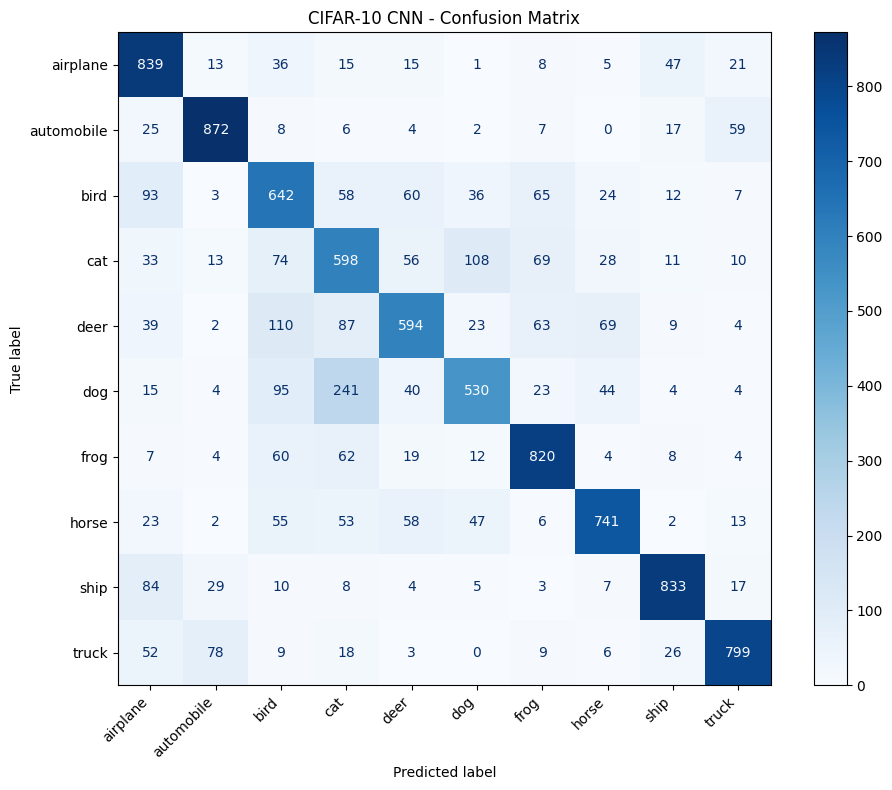

(0.7875712513923645, 0.7268000245094299)

In [9]:
# train and eval on test set
from utils import train_model, eval_classification

basic_cnn_history = train_model(model, X_train_scaled, y_train, "basic_Conv_Net_CIFAR10", epochs=10)
eval_classification(model, X_test_scaled, y_test, class_names, "CIFAR-10 CNN")

## Data Augmentation

For most modern networks that are actually used in production, architecture is not the defining factor - high quality data, and how well it captures the real world problem, is. Often the process of sampling data, getting images etc. is expensive and we cant always have the amount of data we need to train a NN well. 

One mitigation in computer vision is a set data augmentation strategies that mostly consist of **simple affine tranformations** of our input images. This is often:
- Random Crop, Flip, Zoom
- Random Translation (shifting)
- Color or Brightness Jitter

**The cool thing is that we apply those tranformations dynamically to each new batch randomly.**

Lets look at how keras does this with a set of augmentation layers.

NOTE: When we choose augmentations we should always think about what makes sense in a real world setting - which augmentations could exist when we use the model later for prediction? (e.g. compare Horizontal vs Vertical Flip) 

https://keras.io/api/layers/preprocessing_layers/

In [10]:
from keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomTranslation

data_augmentation = keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.1),
    RandomTranslation(0.1, 0.1)
])

augmented_images = data_augmentation(X_train[:12])
augmented_images = augmented_images.numpy().astype(np.uint8)

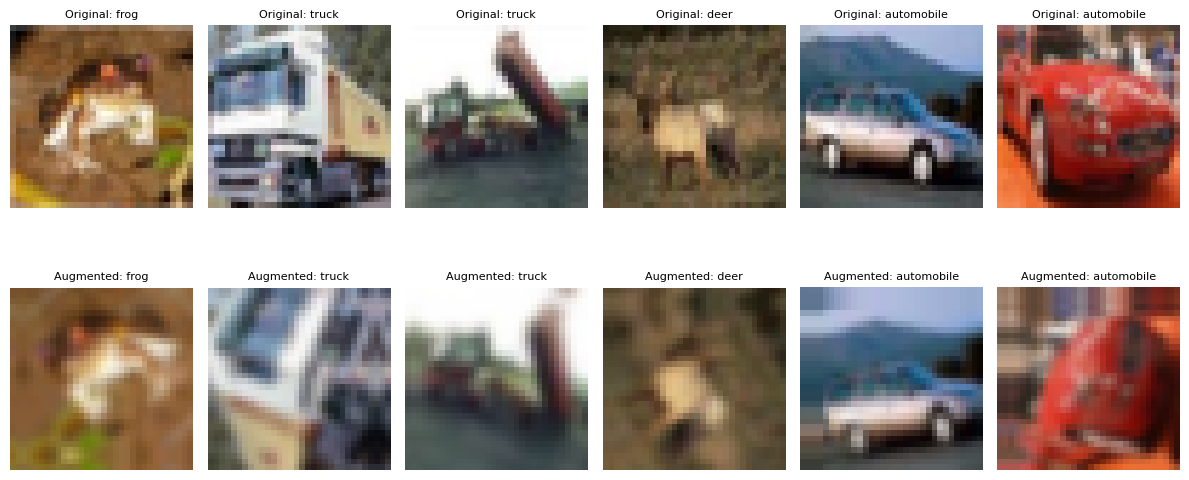

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 6, figsize=(12, 6))
for i in range(6):

    axes[0, i].imshow(X_train[i])
    axes[0, i].set_title(f"Original: {class_names[y_train[i]]}", fontsize=8)
    axes[0, i].axis('off')
    

    axes[1, i].imshow(augmented_images[i].astype(np.uint8))
    axes[1, i].set_title(f"Augmented: {class_names[y_train[i]]}", fontsize=8)
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 0.2841 - loss: 1.9337 - val_accuracy: 0.3626 - val_loss: 1.7820
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 0.3661 - loss: 1.7416 - val_accuracy: 0.3941 - val_loss: 1.7470
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.4064 - loss: 1.6373 - val_accuracy: 0.4424 - val_loss: 1.5329
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.4313 - loss: 1.5704 - val_accuracy: 0.4195 - val_loss: 1.7033
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.4554 - loss: 1.5219 - val_accuracy: 0.4914 - val_loss: 1.4193
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.4730 - loss: 1.4700 - val_accuracy: 0.5276 - val_loss: 1.3298
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 0.4818 - loss: 1.4447 - val_accuracy: 0.5234 - val_loss: 1.3307
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.4976 -

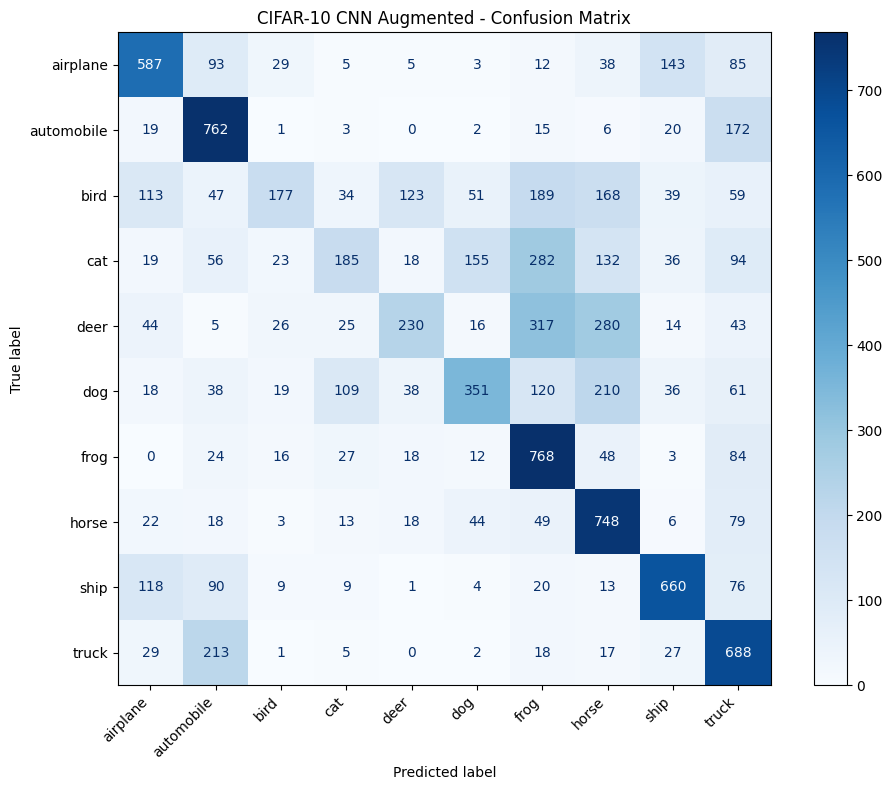

(1.3420401811599731, 0.5156000256538391)

In [ ]:
inputs = Input(shape=(32, 32, 3))
x = data_augmentation(inputs)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(10, activation='softmax')(x)

model_aug = Model(inputs=inputs, outputs=outputs)
model_aug.compile(
    optimizer=keras.optimizers.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)

aug_history = train_model(model_aug, X_train_scaled, y_train, "cnn_augmented_cifar10", epochs=10)
eval_classification(model_aug, X_test_scaled, y_test, class_names, "CIFAR-10 CNN Augmented")

## Transfer Learning

In [13]:
base_model = keras.applications.EfficientNetV2B0(
    include_top=False,  
    weights="imagenet",
    input_shape=(32, 32, 3),  
    pooling=None
)

base_model.trainable = True
inputs = keras.Input(shape=(32, 32, 3))
x = data_augmentation(inputs)
x = base_model(x, training=True)  
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)  
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(10, activation='softmax')(x)
model_effnet = Model(inputs=inputs, outputs=outputs)
model_effnet.compile(
        optimizer=keras.optimizers.Adam(),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
model_effnet.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 1, 1, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,281,434 (23.96 MB)

 Trainable params: 6,220,826 (23.73 MB)

 Non-trainable params: 60,608 (236.75 KB)

In [ ]:
from utils import train_model, eval_classification

effnet_history = train_model(model_effnet, X_train, y_train, "effnetb0_cifar10", epochs=25)
eval_classification(model_effnet, X_test, y_test, class_names, "CIFAR-10 EfficientNetB0")

Epoch 1/25
 621/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 67ms/step - accuracy: 0.2938 - loss: 1.9808